# Analyse Rotation Spectra

## Load Libraries

In [1]:
from andbro__querrySeismoData import __querrySeismoData
from obspy import UTCDateTime
from scipy.signal import welch
from numpy import log10, zeros, pi, append, linspace, mean, median, array, where, transpose, shape, histogram, arange
from pandas import DataFrame, concat, Series, date_range, read_csv
from tqdm import tqdm_notebook
from pathlib import Path

import pickle
import matplotlib.pyplot as plt

In [4]:
!ls "/import/kilauea-data/ROMY/RotationSpectra/data"

overview		       run_2021_RPFO-Z_3600   run_N2_RLAS-Z_1800
run_2019_RLAS-Z_3600	       run_2022_ROMY-Z_3600   run_N2_RLAS-Z_3600
run_2019_ROMY-E_3600	       run_N1_RLAS	      run_N2_ROMY
run_2019_ROMY-Z_3600	       run_N1_ROMY	      run_N2_ROMY-Z_7200
run_2021_ROMY-Z_3600_pfo-days  run_N2019_RLAS-Z_3600  run_N3_RLAS-Z_3600
run_2021_RPFO-E_3600	       run_N2019_ROMY-Z_3600  run_N3_ROMY-Z_3600
run_2021_RPFO-N_3600	       run_N2_RLAS_7200


## Configurations

In [7]:
inname = "run_2021_ROMY-Z_3600_pfo-days"
inpath = f"/import/kilauea-data/ROMY/RotationSpectra/data/{inname}/"

config = pickle.load(open(inpath+inname+"_config.pkl", 'rb'))

config['inname'] = inname
config['inpath'] = inpath

config['frequency_limits'] = [0.002, 30]

## Looping 

In [8]:
def __get_data(config):
    '''
    load data and remove response

    VARIABLES:
    '''

    try:
        st0, inv = __querrySeismoData(    
                            seed_id=config.get('seed'),
                            starttime=config.get('tbeg'),
                            endtime=config.get('tend'),
                            repository=config['repository'],
                            path=None,
                            restitute=False,
                            detail=None,
                            )

    except:
        print(f"failed to load")
#         print(f"failed to load {config.get['seed']} {config.get['tbeg']}")
        return None
    
    try:
        st0.remove_response(inventory=inv,output="VEL", zero_mean=True); 
    except:
        print(f"failed to remove response")
#         print(f"failed to remove response {config.get['seed']} {config.get['tbeg']}")
        return None
    
    return st0

In [9]:
def __get_minimal_psd(psds):

    from numpy import nanmin, array, nonzero
    
    min_psd = zeros(psds.shape[1])
    
    for f in range(psds.shape[1]):
        a = psds[:,f]
        min_psd[f] = nanmin(a[nonzero(a)])
    
    return min_psd

In [10]:
def __get_minimum_psd(psds, f_tmp):
    
    from numpy import median
    
    f_before = f_tmp[0]
    f_tmp[0] = 1e-9
    
    for i, psd in enumerate(psds):
        if i == 0: 
            lowest_value = (psds[0]/f_tmp).sum()
#             lowest_value = median(psds[0]/f_tmp)
            idx = 0

        value = (psd/f_tmp).sum() 
#         value = median(psd/f_tmp)
        
        if value < lowest_value and value != 0:
            lowest_value = value
            idx = i

    f_tmp[0] = f_before      
    
    return psds[idx]

In [11]:
def __save_config(config):
    
    ofile = open(config['outpath']+config['outname']+"_config.pick", 'wb')
    pickle.dump(config, ofile)

    if Path(config['outpath']+config['outname']+"_config.pick").exists():
        print(f"created: {config['outpath']}{config['outname']}_config.pick")

In [12]:
def __write_to_csv(data, text, config):
    
    import csv
    
    opath = config['outpath']
    oname = config['outname']+"_"+text+"_psd.csv"
    
    # open the file in the write mode
    with open(opath+oname, 'w') as file:

        writer = csv.writer(file)
        for row in data:
            writer.writerow(row)
            
    if Path(opath+oname).exists():
        print(f"created: {opath}{oname}")

In [13]:
def __calculate_spectra(st, config, mode='dB'):

    from datetime import datetime
    from pandas import date_range
    from obspy import UTCDateTime
    from scipy.signal import welch
    from numpy import where, array, zeros
    
    def __check_stream(st):
        t1 = str(st[0].stats.starttime)
        t2 = str(st[0].stats.endtime)
        for tr in st:
            if str(tr.stats.starttime) != t1 or str(tr.stats.endtime) != t2:
                print(f"ERROR: mismatch in start or endtime of trace: {tr.stats.id}")
                return
            
    def __make_decibel(array, relative_value):
        return 10*log10(array/relative_value) 
    
    ## check time consistency for all traces
    __check_stream(st)
    
    ## check how many intervals are possible
    if config['interval_overlap'] is None:
        intervals = int((st[0].stats.endtime - st[0].stats.starttime)/config.get('interval'))
        shift = config['interval']
    else:
        shift = int(config.get('interval')*config['interval_overlap']/100)
        intervals = int((st[0].stats.endtime - st[0].stats.starttime)/shift)
    


    ## pre-define psd array
    size_psd = int(config.get('nperseg')/2)+1
    psd = zeros([intervals, size_psd])
    
    if size_psd >= len(st[0].data):
        print(f"ERROR: reduce nperseg or noverlap or segments! {size_psd} > {len(st[0].data)}")
        return
    
    for i, tr in enumerate(st):
        
        # initite variables for while loop
        dt1 = st[0].stats.starttime
        dt2 = st[0].stats.starttime + config['interval']
        n = 0
        
        while dt2 <= st[0].stats.endtime:

            tr_tmp = tr.copy()
            tr_tmp.trim(starttime = UTCDateTime(dt1), endtime=UTCDateTime(dt2))

#             print(n, dt1, dt2, "\n")
            
#             print(config.get('nperseg'), config.get('noverlap'), len(tr_tmp.data))
            
            f, psd0 = welch(  
                        tr_tmp.data, 
                        fs=tr_tmp.stats.sampling_rate, 
                        window=config.get('taper'), 
                        nperseg=config.get('nperseg'), 
                        noverlap=config.get('noverlap'), 
                        nfft=config.get('nfft'), 
                        detrend=config.get('detrend'), 
                        return_onesided=config.get('onesided'), 
                        scaling=config.get('scaling'),
                       )
            psd[n] = psd0
            
            ## adjust variables
            dt1 += shift
            dt2 += shift
            n += 1

            
        if config.get('frequency_limits') is not None:
            f1, f2 = config.get('frequency_limits')[0], config.get('frequency_limits')[1]
            idx1, idx2 = int(where(f <= f1)[0][0]), int(where(f >= f2)[0][0])
            ff = f[idx1:idx2]
            tmp = zeros([intervals, len(ff)])
            for j in range(intervals):
                tmp[j] = psd[j,idx1:idx2]
            psd = tmp

        if mode is not None and mode.lower() == 'db':
            for j in range(intervals):
                psd[j] = __make_decibel(psd[j], abs(max(psd[j])))
   
    return ff, psd

In [14]:
def __loop(config):
    
    days = int((config['date2'] - config['date1'])/86400)+1

    minimum_collection = []
    minimal_collection = []
    columns = []

    for date in tqdm_notebook(date_range(str(config['date1'].date), str(config['date2'].date), days, closed='left')):

        config['tbeg'] = UTCDateTime(date)
        config['tend'] = UTCDateTime(date) + 86400

        st = __get_data(config)

        if st is None or st[0].stats.npts < 1000:
            print(f"skipping {date}")
            continue

        ff, psds = __calculate_spectra(st, config, mode=None)

        minimal_psd = __get_minimal_psd(psds)
        minimal_collection.append(minimal_psd)

        minimum_psd = __get_minimum_psd(psds, ff)
        minimum_collection.append(minimum_psd)

        ## write out column names
        columns.append(str(date)[:10])
        with open(config['outpath']+config['outname']+"_columns.pick", 'wb') as ofile:
            pickle.dump(columns, ofile)

        ## store frequency axis
        with open(config['outpath']+config['outname']+"_frequency_axis.pick", 'wb') as ofile:
            pickle.dump(ff, ofile)


    __write_to_csv(minimal_collection, "minimal", config)
    __write_to_csv(minimum_collection, "minimum", config)

    __save_config(config)

In [15]:
def __load_psds(file, config):

    ## get data to dataframe and transpose and reindex
    df = read_csv(file, index_col=False)
    df = df.transpose()
    df.reset_index(inplace=True)
    # df.dtypes
    # df.mean()

    ## set column names
    try:
        columns = pickle.load(open(f"{config['inpath']}{config['inname']}_columns.pick", 'rb'))
        df.columns = [column.replace("-","") for column in columns]
    except:
        print(" -> Failed to assign column names!")

    ## check for column dublicates
    if len(df.columns.unique()) != len(df.columns):
        print(f" -> removing {len(df.columns)-len(df.columns.unique())} column dublicate(s)!")
        df = df.loc[:,~df.columns.duplicated()]

    count=0
    dates_expected = date_range(config['date1'].date, config['date2'].date, periods=int((config['date2']-config['date1'])/86400)+1)
    for dex in dates_expected:
        dex=str(dex.isoformat()[:10]).replace("-","")
        if not dex in df.columns:
            count+=1
    print(f" -> missing {count} days")
        
        
#     ## convert to list
#     psds = []
#     for col in array(df.columns):
        
#         ## turn non-float series to float objects
#         df[col] = pd.to_numeric(df[col], errors = 'coerce')

#         ## add to psds list
#         psds.append(array(df[col]))
        
    return df

In [16]:
def __get_array_from_dataframe(df):
    
    from pandas import to_numeric
    
    ## convert to list
    psds = []
    for col in array(df.columns):
        
        ## turn non-float series to float objects
        df[col] = to_numeric(df[col], errors = 'coerce')

        ## add to psds list
        psds.append(array(df[col]))

    return array(psds)

In [17]:
def __remove_noise_psds(df, threshold=1e-13):

    from numpy import delete
    
    l1 = len(df.columns)
    for col in df.columns:
#         print(col, type(col))
        if df[col].astype(float).mean() > threshold:
            df = df.drop(columns=col)
    l2 = len(df.columns)
    print(f" -> removed {l1-l2} columns due to mean thresholds!")
 
    return df

In [18]:
## load set of minimum psds
file = f"{config['inpath']}{config['inname']}_minimum_psd.csv"
minimum = __load_psds(file, config)

## load minimal possible psds
file = f"{config['inpath']}{config['inname']}_minimum_psd.csv"
minimal = __load_psds(file, config)

## load frequencies
ff = pickle.load(open(f"{config['inpath']}{config['inname']}_frequency_axis.pick", 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: '/import/kilauea-data/ROMY/RotationSpectra/data/run_2021_ROMY-Z_3600_pfo-days/run_2021_ROMY-Z_3600_pfo-days_minimum_psd.csv'

In [19]:
minimal = __remove_noise_psds(minimal, threshold=1e-18)
minimum = __remove_noise_psds(minimum, threshold=1e-18)

NameError: name 'minimal' is not defined

Convert dataframes to array / matrix

In [20]:
psds_minimal = __get_array_from_dataframe(minimal)
psds_minimum = __get_array_from_dataframe(minimum)

del minimal, minimum

NameError: name 'minimal' is not defined

Cut to frequency axis and matrices to frequency limits as specified in config

In [21]:
ind = []
for i,f in enumerate(ff):
    if f >= config['frequency_limits'][0] and f <= config['frequency_limits'][1]:
        ind.append(i)
a, b = ind[0], len(ff)-ind[-1]

ff = ff[ind[0]:ind[-1]]
psds_minimal = psds_minimal[:,ind[0]:ind[-1]]
psds_minimum = psds_minimum[:,ind[0]:ind[-1]]

NameError: name 'ff' is not defined

Get overall minium and minimal PSD

In [214]:
minimals_minimal = __get_minimal_psd(array(psds_minimal))
minimums_minimum = __get_minimum_psd(array(psds_minimum), ff)

## Plotting

In [221]:
def __makeplot_colorlines(config, ff, psds_minimal, psds_minimum, columns):

    fig, ax = plt.subplots(2,2, figsize=(15,10), sharey=False, sharex=True)

    font = 12

    N = psds_minimum.shape[0]
    colors = plt.cm.rainbow(linspace(0, 1, N))


    for n, psd in enumerate(psds_minimum):
        ax[0][0].loglog(ff, psd, color=colors[n])

    for n, psd in enumerate(psds_minimal):
        ax[0][1].loglog(ff, psd, color=colors[n])

    ## add scatter for colorbar object only
    for n, psd in enumerate(psds_minimal):
        p2 = ax[0][1].scatter(ff[0], psd[0], s=0., c=n, cmap='rainbow', vmin=0, vmax=N)


    ax[0][0].loglog(ff, minimals_minimal, 'k')
    ax[0][1].loglog(ff, minimums_minimum, 'k')

    ax[1][0].loglog(ff, minimals_minimal, 'k')
    ax[1][1].loglog(ff, minimums_minimum, 'k')

    ax[0][0].set_title("Minimal PSD", fontsize=font)
    ax[0][1].set_title("Minimum PSD", fontsize=font)

    ax[1][0].set_xlabel("Frequency (Hz)", fontsize=font)
    ax[1][1].set_xlabel("Frequency (Hz)", fontsize=font)

    ax[1][0].set_ylabel(r"PSD (rad$^2$/s$^2$/$\sqrt{Hz})$", fontsize=font)
    ax[1][0].set_ylabel(r"PSD (rad$^2$/s$^2$/$\sqrt{Hz})$", fontsize=font)

    
    ax[0][0].grid(True, which="both", ls="-", alpha=0.5)
    ax[0][1].grid(True, which="both", ls="-", alpha=0.5)
    ax[1][0].grid(True, which="both", ls="-", alpha=0.5)
    ax[1][1].grid(True, which="both", ls="-", alpha=0.5)
    
    ax[0][0].set_xlim(10**log10(min(ff)), 10**log10(max(ff)))
    ax[0][1].set_xlim(10**log10(min(ff)), 10**log10(max(ff)))
#     ax[0][0].set_xlim(10**log10(config['frequency_limits'][0]), 10**log10(config['frequency_limits'][1]))
#     ax[0][1].set_xlim(10**log10(config['frequency_limits'][0]), 10**log10(config['frequency_limits'][1]))
    
    ## set colorbar at bottom
    cbar = fig.colorbar(p2, orientation='horizontal', ax=ax, aspect=50)

    ## redefine ticks of colorbar
    dates = columns
    new_ticks=[]
    for t in cbar.get_ticks(): 
        new_ticks.append(dates.astype(str)[int(t)])
    cbar.ax.set_xticklabels(new_ticks)


    plt.show();
    return fig

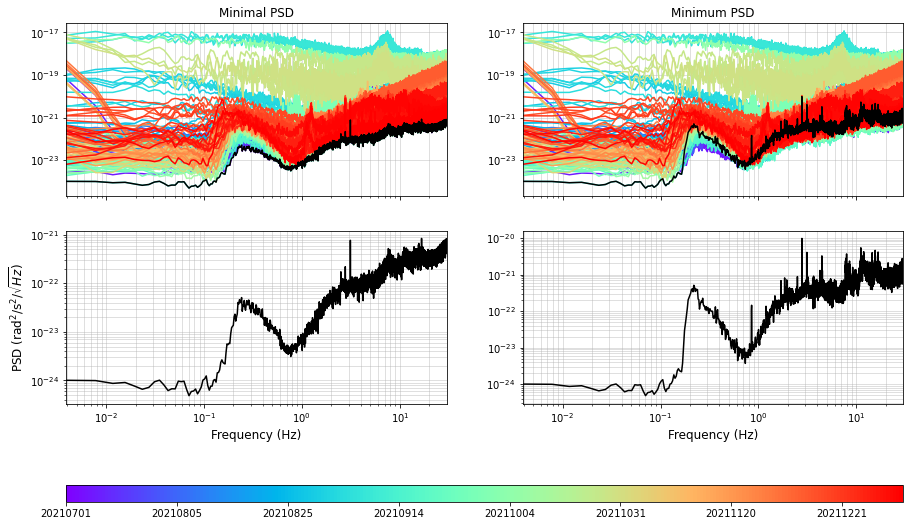

In [222]:
fig = __makeplot_colorlines(config, ff, psds_minimal, psds_minimum, minimal.columns)

Convert to logaritmic values

In [223]:
from numpy import logspace, linspace, log, log10

print(psds_minimal.shape)

for i, psd in enumerate(psds_minimal):
#     psds_minimal[i,:] = 10**(psds_minimal[i,:]/10)
    psds_minimal[i,:] = log10(psds_minimal[i,:])
    
for i, psd in enumerate(psds_minimum):
#     psds_minimum[i,:] = 10**(psds_minimum[i,:]/10)
    psds_minimum[i,:] = log10(psds_minimum[i,:])


print(psds_minimal.shape)

(151, 7679)
(151, 7679)


## Calculate and Plot Density

In [224]:
def __calculate_density(psd_array, bins=20):

    from numpy import argmax, std, median

    max_value = max([max(sublist) for sublist in psd_array])
    min_value = min([min(sublist) for sublist in psd_array])


    dist, dist_maximas, bins_maximas, bins_medians, stds = [], [], [], [], []

    for h in range(len(psd_array[1])):
        
        psd = psd_array[:,h]
        
        hist, bin_edges = histogram(psd, bins=bins, range=(min_value, max_value), density=None);
        
        bin_mids = 0.5*(bin_edges[1:] + bin_edges[:-1])
        
        dist.append(hist)
        stds.append(std(hist))
        dist_maximas.append(max(hist))
        bins_maximas.append(bin_mids[argmax(hist)])
        bins_medians.append(median(psd[psd != 0]))
        

    output = {}
    output['dist'] = array(dist)
    output['bin_mids'] = array(bin_mids)
    output['bins_maximas'] = array(bins_maximas)
    output['stds'] = array(stds)
    output['bins_medians'] = array(bins_medians)
    
    return output

In [243]:
def __makeplot_PPSD(ff, output, config):

    from matplotlib import colors

    # from pandas import Series
    # new = Series(10**edge_maximas).rolling(5, min_periods=1, center=True).mean()
    # edge_maximas = log10(array(new))

    # ff[0] = ff[1]

    bins, bins_medians, bins_maximas, dist = output['bin_mids'], output['bins_medians'], output['bins_maximas'], output['dist']
    
    y_axis = 10**bins
    x_axis = ff


    ## plotting
    fig = plt.figure(figsize=(13,6))

    font=14

    cmap = plt.cm.get_cmap('magma_r')
    cmap.set_under(color='white')

    im = plt.pcolor(x_axis, y_axis, dist.T, 
                    cmap=cmap,
                    vmin=1e-12, 
    #                 norm=colors.LogNorm(), 
                   )

    fs = x_axis[2]-x_axis[1]
#     plt.plot(x_axis+fs/2, 10**array(bins_maximas), color='black', alpha=0.5)
    plt.plot(x_axis+fs/2, 10**array(bins_medians), color='black', alpha=0.5)


    plt.xscale('log')
    plt.yscale('log')

    plt.ylim(min(y_axis), max(y_axis))
#     plt.xlim(config['frequency_limits'][0], config['frequency_limits'][1])

    caxes = fig.add_axes()

    cb = plt.colorbar(im, cax=caxes)
    cb.set_label("counts", fontsize=font)
    
    plt.ylabel(r"PPSD (rad$^2$/s$^2$/$\sqrt{Hz})$", fontsize=font)
    # plt.ylabel(f"PSD (dB rel. to {round(max_value,3)} V$^2$/Hz )",fontsize=font)
    plt.xlabel("Frequency (Hz)",fontsize=font)
    plt.title(f"PPSD {config['ring']} [{config['date1'].date} - {config['date2'].date}]",fontsize=font+2)

    
    plt.tick_params(axis='both', labelsize=font-2)

    plt.show();
    return fig

In [237]:
def __makeplot_model(ff, bins, bins_maxima, stds):

    from matplotlib import colors

    # from pandas import Series
    # new = Series(10**edge_maximas).rolling(5, min_periods=1, center=True).mean()
    # edge_maximas = log10(array(new))

    # ff[0] = ff[1]


    y_axis = 10**bins
    x_axis = ff


    ## plotting
    fig = plt.figure(figsize=(10,5))

    font=14

    plt.plot(x_axis, 10**array(bins_maximas), color='black', alpha=1.)
    
#     plt.plot(x_axis, 10**array(bins_maximas+stds), color='black', alpha=0.5)
#     plt.plot(x_axis, 10**array(bins_maximas-stds), color='black', alpha=0.5)

    plt.fill_between(x_axis, 10**array(bins_maximas-stds**.5),10**array(bins_maximas+stds**0.5), color='grey', alpha=0.7)

    plt.xscale('log')
    plt.yscale('log')

    # plt.ylim(min(y_axis), max(y_axis))
    # plt.xlim(min(x_axis), max(x_axis))

    plt.ylabel(r"PSD (rad$^2$/s$^2$/$\sqrt{Hz})$", fontsize=font)
    plt.xlabel("Frequency (Hz)",fontsize=font)

    plt.xlim(10**log10(0.01), 10**log10(20))
    
    # plt.ylabel(f"PSD (dB rel. to {round(max_value,3)} V$^2$/Hz )",fontsize=font)
    # plt.title(f"Sagnac Spetra on {date.date} ({interval}s windows) ",fontsize=font+2)

    plt.tick_params(axis='both', labelsize=font-2)

    plt.show();
    return fig

## Minimal

In [238]:
output = __calculate_density(psds_minimal, bins=50)

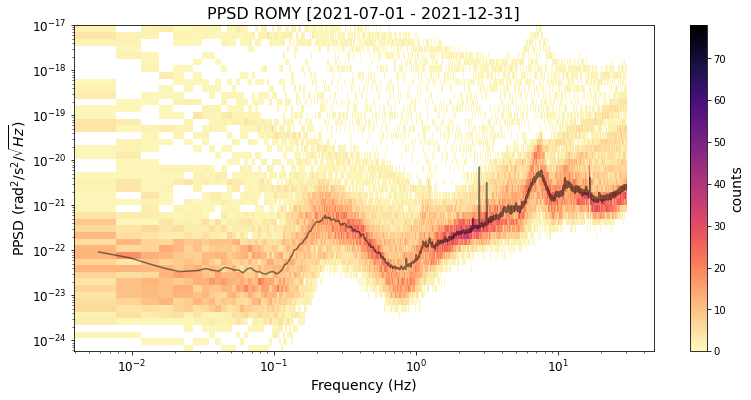

In [244]:
fig = __makeplot_PPSD(ff, output, config)

In [240]:
# fig = __makeplot_model(ff, bins, bins_maximas, stds)

## Minimum

In [241]:
output = __calculate_density(psds_minimum, bins=50)

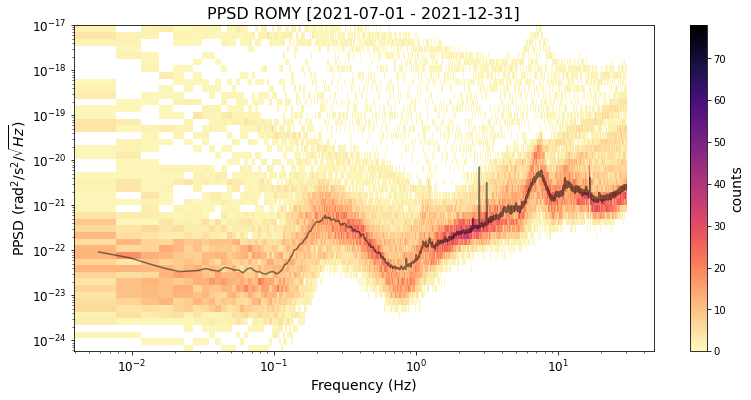

In [245]:
fig = __makeplot_PPSD(ff, output, config)

In [ ]:
# fig = __makeplot_model(ff, bins, bins_maximas, stds)

In [ ]:
# fig.savefig(
#             opath+f"plot_sagnacspectra_{date.date}_{interval}_distribution.png", 
#             dpi=300, facecolor='w', 
#             edgecolor='w',
#             orientation='portrait', 
#             format="png",
#             transparent=False, 
#             bbox_inches="tight", 
#             pad_inches=0.2,
#            )